In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10,7)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Load the dataset
plant_data = pd.read_csv("plant.csv")
plant_data.tail(10) 

,temperature,humidity,denomination
90,16.37,45.07,0
91,30.94,46.15,0
92,20.53,43.41,1
93,16.99,78.17,0
94,30.47,62.65,0
95,20.90,42.04,1
96,28.36,30.22,0
97,25.15,31.58,0
98,27.00,32.56,0
99,23.45,33.30,0


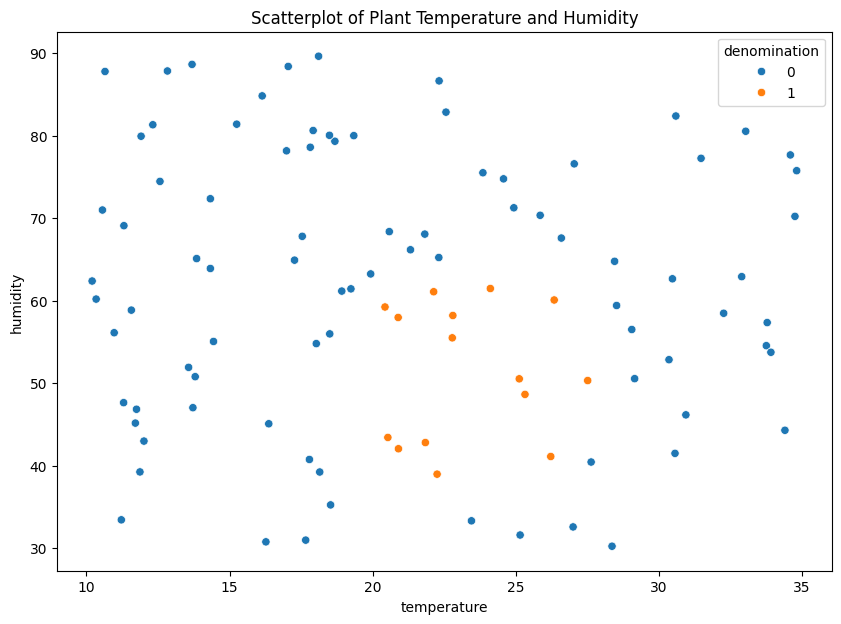

In [3]:
# Visualize using a scatterplot (0 = unhealthy, 1 = healthy)
sns.scatterplot(x="temperature", y="humidity", data=plant_data, hue="denomination")
plt.title("Scatterplot of Plant Temperature and Humidity")
plt.show()


In [4]:
# Prepare the data for training and testing
X = plant_data[["temperature", "humidity"]].to_numpy()
y = plant_data['denomination'].values 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the input test and train features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Export scaler object so aws.py can use it
f = open('scaler.pkl', 'wb')
pickle.dump(scaler, f)

In [5]:
# Define the model
model = Sequential([
    layers.Input(shape=(2,)),          
    layers.Dense(64, activation='relu'), 
    layers.Dense(64, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=0)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

**#experiement with the accuracy if used only 1 middle layer vs. 2 and so on**

In [6]:
# Print accuracy score
loss,acc = model.evaluate(X_test, y_test)
print("accuracy: ", acc)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9500 - loss: 0.0535
accuracy:  0.949999988079071


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 372us/step


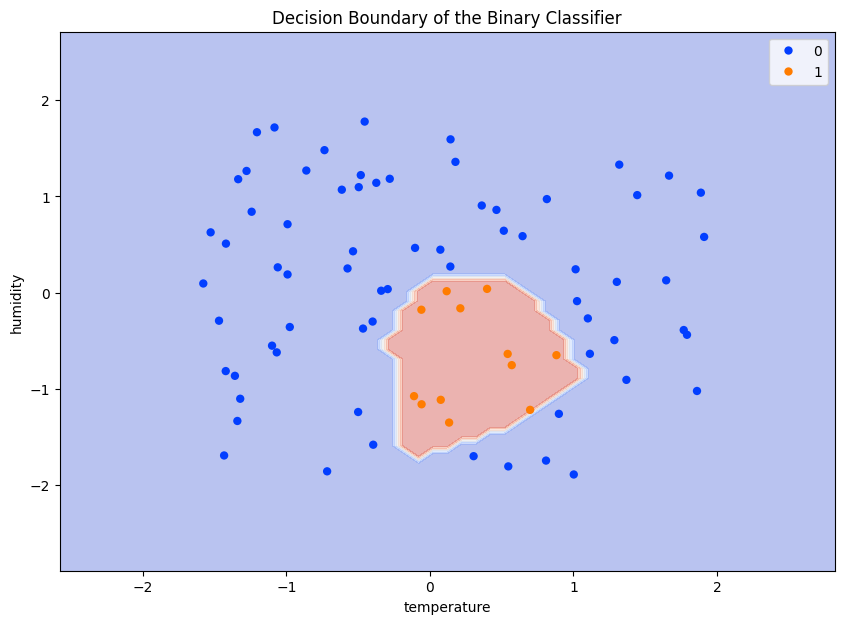

In [7]:
# Plot the Decision Boundary
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.round(Z).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.coolwarm)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y.flatten(), palette='bright', edgecolor="none")
    plt.xlabel('temperature')
    plt.ylabel('humidity')
    plt.title('Decision Boundary of the Binary Classifier')
    plt.show()

plot_decision_boundary(X_train, y_train, model)

In [8]:
# Export the model so aws.py can use it
model.save('model.keras')

In [9]:
# Query AWS IOT Sitewise for latest value
import boto3

sitewise_client = boto3.client('iotsitewise', 'us-east-1')

asset_id = 'f61fd66e-ccd5-4eb3-9bd8-9cf88ce84c92'
temp_id = 'ee288f99-f1dc-4124-a346-c85e12f6c305' #property id
hum_id = 'dd024614-b04b-4820-91e9-48442c8982bf' #property id
light_id = '85b95849-2117-4eff-844a-c70f0473308b' #property id

try:
    temp_response = sitewise_client.get_asset_property_value(
        assetId=asset_id,
        propertyId=temp_id
    )
    hum_response = sitewise_client.get_asset_property_value(
        assetId=asset_id,
        propertyId=hum_id
    )
    light_response = sitewise_client.get_asset_property_value(
        assetId=asset_id,
        propertyId=light_id
    )
    
    temp = temp_response['propertyValue']['value']['doubleValue']
    hum = hum_response['propertyValue']['value']['doubleValue']
    lux = light_response['propertyValue']['value']['doubleValue']
    
    print(f"Temperature: {temp}")
    print(f"Humidity: {hum}")    
    print(f"Lux: {lux}")  
      
except Exception as e:
        print("Error:", e)


Temperature: 20.0
Humidity: 63.0
Lux: 150.59


In [10]:
# Format sensor data
sensor_data = pd.DataFrame({
    "temperature": [temp],
    "humidity": [hum],
})
sensor_data = scaler.transform(sensor_data[["temperature", "humidity"]].to_numpy())

# Use the model to make predictions
pred = model.predict(sensor_data)
pred = np.round(pred).astype(int).flatten()
if pred[0] == 0:
    output = "unhealthy plant"
    plant = "unhealthy"
    color = "red"
else:
    output = "healthy plant"
    plant = "healthy"
    color = "green"
if lux > 100:
    output += ", day"
    day = "day"
else:
    output += ", night"
    day = "night"
    
print("prediction: ", output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
prediction:  unhealthy plant, day


In [ ]:
from flask import Flask, render_template

app = Flask(__name__)

@app.route("/")
def home():
    return render_template("index.html", plant=plant, color=color, day=day)

if __name__ == "__main__":
    app.run(debug=False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [03/Dec/2024 06:28:08] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Dec/2024 06:28:09] "GET /static/day.jpg HTTP/1.1" 200 -
127.0.0.1 - - [03/Dec/2024 06:28:09] "GET /static/unhealthy.jpg HTTP/1.1" 200 -
